In [5]:
import tinySA as tn
import numpy as np
import matplotlib.pyplot as plt


In [3]:
def clearBuffer(self):
    self.usb.timeout = 1
    while self.usb.inWaiting():
        self.usb.read_all()  # keep the serial buffer clean
        time.sleep(0.01)

self.fifoTimer = QtCore.QTimer()
self.fifoTimer.timeout.connect(self.usbSend)

NameError: name 'QtCore' is not defined

In [ ]:
def scan_freq(start, stop):
    """
    Send a scan command from a frequency of start to a frequency of stop

    Returns: tuple(frequency[Hz], bin power [logmag])
    """
    
    my_sa.fetch_frequencies()
    freq = my_sa._frequencies

    my_sa.send_command("scan %d %d\r"%(freq_start, freq_stop))
    data = my_sa.data(0)

    return (freq, data)

In [2]:
import numpy as np
import serial
from serial.tools import list_ports
import time
import struct
import argparse
import sys

import matplotlib.pyplot as plt


# tinysa USB IDs
VID = 0x0483
PID = 0x5740

F_LOW = 0
F_HIGH = 350000000
POINTS = 101


# Get tinysa device automatically
def getport() -> str:
    device_list = list_ports.comports()
    for device in device_list:
        if device.vid == VID and device.pid == PID:
            return device.device
    raise OSError("device not found")


# return 1D numpy array with power as dBm
def get_tinysa_dBm( s_port, f_low=F_LOW, f_high=F_HIGH, points=POINTS, rbw=0, verbose=None ) -> np.array:
    with serial.Serial( port=s_port, baudrate=115200 ) as tinySA:
        tinySA.timeout = 1
        while tinySA.inWaiting():
            tinySA.read_all() # keep the serial buffer clean
            time.sleep( 0.1 )

        if 0 == rbw: # use tinySA values
            rbw_k = (f_high - f_low) * 7e-6 # RBW / kHz
        else:
            rbw_k = rbw / 1e3

        if rbw_k < 3:
            rbw_k = 3
        elif rbw_k > 600:
            rbw_k = 600

        rbw_command = f'rbw {int(rbw_k)}\r'.encode()
        tinySA.write( rbw_command )
        tinySA.read_until( b'ch> ' ) # skip command echo and prompt

        # set timeout accordingly - can be very long - use a heuristic approach
        timeout = ((f_high - f_low) / 20e3) / (rbw_k ** 2) + points / 500 + 60
        tinySA.timeout = timeout * 2

        if verbose:
            sys.stderr.write( f'frequency step: {int( (f_high - f_low) / ( points-1 ) / 1e3 )} kHz\n' )
            sys.stderr.write( f'RBW: {int(rbw_k)} kHz\n' )
            sys.stderr.write( f'serial timeout: {timeout} s\n' )

        scan_command = f'scanraw {int(f_low)} {int(f_high)} {int(points)}\r'.encode()
        tinySA.write( scan_command )
        tinySA.read_until( b'{' ) # skip command echoes, TODO check if returned size > 0
        raw_data = tinySA.read_until( b'}ch> ' ) # TODO repeat until complete
        #tinySA.write( 'rbw auto\r'.encode() ) # switch to auto RBW for faster tinySA screen update


    # print('<' + 'xH'*points)
    # print(struct.calcsize('<' + 'xH'*points))
    # print(len(raw_data[:-5]))
    # print(raw_data)

    
          
    raw_data = struct.unpack( '<' + 'xH'*points, raw_data[:-5] ) # ignore trailing '}ch> '
    raw_data = np.array( raw_data, dtype=np.uint16 )
    # tinySA:  SCALE = 128
    # tinySA4: SCALE = 174
    SCALE = 174
    dBm_power = raw_data / 32 - SCALE # scale 0..4095 -> -128..-0.03 dBm
    return dBm_power

In [ ]:
portSA = getport()

# Set up the serial connection (update 'COM3' or '/dev/ttyUSB0' to your port)
arduino = serial.Serial('/dev/ttyACM0', 9600, timeout=1)
time.sleep(2)  # Allow time for the Arduino to reset

def control_led(command):
    """Send a command to the Arduino to control LEDs."""
    arduino.write(command.encode())
    print(f"Sent command: {command}")

red    = "1"
yellow = "2"
green  = "3"
    
def check_levels(levels):

    if np.max(levels) > -80:
        return red
    elif np.max(levels) > -90:
        return yellow
    else:
        return green

control_led(red)
time.sleep(1)
control_led(yellow)
time.sleep(1)
control_led(green)


try:
    while True:

        light = "green"
        
        print("\nCommands:")
        print("M: Measure")
        print("Q: Quit")

        cmd = input("Enter a command: ").strip()

        if cmd.upper() == 'M':
            levels = get_tinysa_dBm(portSA, f_low=80E6, f_high=100E6, points=1000, rbw=100E3)
            light  = check_levels(levels)

            

        if cmd.upper() == 'Q':
            break

        control_led(light)

finally:
    arduino.close()
    print("Connection closed.")



In [3]:

import queue
import threading
import random
import csv
import copy
import h5py
import time


In [ ]:



# Example run struct
# runs = [
#     {
#         'name': 'Run1',
#         'time': '2025-01-20 10:00:00',
#         'frequency': np.array([1, 2, 3]),
#         'power': np.array([10, 20, 30])
#     },
#     {
#         'name': 'Run2',
#         'time': '2025-01-20 11:00:00',
#         'frequency': np.array([4, 5, 6]),
#         'power': np.array([40, 50, 60])
#     }
# ]


# Define a custom function to take a measurement (simulated with a random number)
def take_measurement(f_low=0.4E9, f_high=1.6E9, points=10000, rbw=100E3):
    # Simulate taking a measurement with a random number
    # return random.uniform(0, 100)
    time.sleep(30)
    return np.array(get_tinysa_dBm(portSA, f_low=0.4E9, f_high=1.6E9, points=1000, rbw=100E3), dtype='float64')


# Function to take 5 measurements and return their average
def average_measurements():
    
    stacked_arrays = np.vstack([take_measurement() for _ in range(5)])

    # Calculate the mean along the first axis (axis=0)
    # average = np.mean(stacked_arrays, axis=0)
    average = np.max(stacked_arrays, axis=0)
    
    return average

# Function to process the measurement queue
def process_queue(measurement_queue, results):
    while not measurement_queue.empty():
        run = measurement_queue.get()
        
        print(f"Processing measurement task: {run['name']}")
        
        # Take and print the average of 5 measurements
        avg = average_measurements()
        # print(f"Average of
        # 5 measurements: {avg:.2f}")

        f_low=0.4E9
        f_high=1.6E9
        rbw=100E3
        points=1000

        np.array(get_tinysa_dBm(portSA, f_low=0.4E9, f_high=1.6E9, points=points, rbw=rbw), dtype='float64')
        
        # Store the result with label
        run['power']    = avg
        run['frequency'] = np.linspace(f_low, f_high, points)
        
        run_copy = copy.deepcopy(run)
        results.append(run_copy)
        
        measurement_queue.task_done()
        
        time.sleep(1)  # Simulate time taken to process the task

def save_to_csv(filename, results):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Label", "Average"])
        writer.writerows(results)
    print(f"Results saved to {filename}")

def save_to_hdf5(filename, runs):

    #TODO: add try catch 
    with h5py.File(filename, 'a') as f:
        for run in runs:
            group = f.create_group(run['name'])
            group.attrs['time'] = run['time']
            group.create_dataset('frequency', data=run['frequency'])
            group.create_dataset('power', data=run['power'])

    print("Data stored successfully.")
    
def main():
    try :
        portSA = getport()
    except OSError as E:
        print(f"{E} No tinySA connected.")
        return 
    
    # Create a queue to hold measurement tasks
    measurement_queue = queue.Queue()
    results = []

    # Allow manual modifications to the setup
    while True:
        modify = input("Do you want to do another run (yes/no)? ").strip().lower()
        if modify == 'yes':
            label = input("Enter the label for the new run: ").strip()
            
            measurement_queue.put(
                {
                'name': label,
                'time': time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())),
                'frequency': None,
                'power': None,
                'rbw': None,
                'runtype': "max_hold", #options: max_hold, average
                'num_frame': 5,         #number of frames for averaging
                'comment': "No comment"
                    
               })
            
            thread = threading.Thread(target=process_queue, args=(measurement_queue, results))
            thread.start()
            measurement_queue.join()
        else:
            break

    # Save the results to a CSV file
    # print(results)
    
    save_to_hdf5("real_measurement_results_2.h5", results)
    
    

if __name__ == "__main__":
    main()

In [ ]:

# Open the HDF5 file
def read_run(target_name):
    with h5py.File('real_measurement_results_2.h5', 'r') as f:
        group = f[target_name]
        # time = group['time']
        frequency = group['frequency'][:]
        power = group['power'][:]
        
    return [frequency, power] 
            
def quick_plot(runs, split=0):
    """
    input: array of run names to plot
    
    """

    delta = 0
    
    for run in runs:

        if '!' in run:
            continue
        
        frequency, power = read_run(run)

        if split:
            power = power + delta
            delta +=  split

        
        
        plt.ylim(-110, -0)
        
        plt.plot(frequency, power, label=run)
        
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('dBm')
        plt.legend()
        # plt.plot()
        
        

with h5py.File('real_measurement_results_2.h5', 'r') as f:
    for run_name in f:
        print(f"Run: {run_name}")
        # print(f"Frequency: {frequency}")
        # print(f"Power: {power}")

# print(read_run('rf_generator_open_door'))
# print("Data read successfully.")

In [7]:
np.shape(np.loadtxt("gain_cal.csv", delimiter=',', skiprows=1))

(9970, 4)

-35.82640523131566


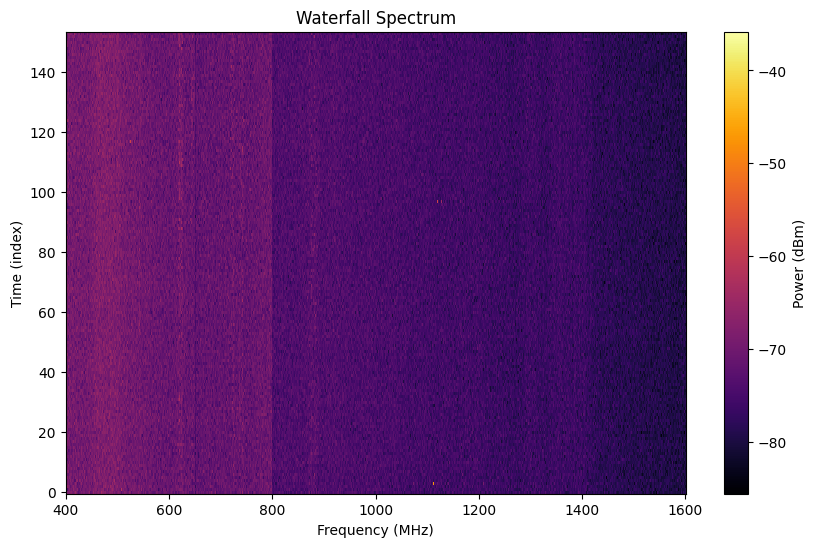

In [10]:
import glob

# run  = ['!closed_cal' , 'max_hold_cal', '!max_hold_cal_2', 'phone_5stack_max_hold_test_1', 'phone_5stack_maxhold_test_2','!tiny_sa_with_dipole_rfi_test_1','!tiny_sa_no_dipole_test_1', 'open_faraday_cage_test_3']
# # run  = ['closed_cal' , 'phone_5stack_max_hold_test_1', 'phone_5stack_maxhold_test_2','phone_headphone_test_1']

# # run  = ['closed_cal' , 'closed_faraday_50ohm_termination_test_2', 'open_faraday_50ohm_termination_test_2' ]
# quick_plot(["cryo_closed_phone_1","cryo_door_closed_keyfob_1"], split=0)



def scale(db, freq):
    gain_cal = pd.read_csv("gain_cal.csv")
    gain_scale = np.interp(freq, gain_cal["Frequency"], gain_cal['dB'])


    return db + gain_scale


directory = "./march_20_spectrum/rfi_box_phone_1/*"


# Get all file paths matching the pattern
file_list = sorted(glob.glob(directory))  # Adjust path pattern as needed

power_data = []  # List to store power matrices
time_stamps = []  # Time steps (assume evenly spaced)

for i, file in enumerate(file_list):
    freq, power = snapshot = np.loadtxt(file, delimiter=' ')  # Load power values
    power_data.append(power)
    time_stamps.append(i)  # Assume evenly spaced time steps

# 🔹 Step 2: Convert list to 2D array
power_data = np.array(power_data)  # Shape (time_steps, freq_bins)



# 🔹 Step 3: Define frequency bins (assuming known range)
freq_bins = np.linspace(400, 1600, power_data.shape[1])  
power_data = scale(power_data, freq_bins*1E6)

# 🔹 Step 4: Create the Waterfall Plot
plt.figure(figsize=(10, 6))

# power_data = scale(power_data, freq_bins)
print(np.max(power_data))

# plt.pcolormesh(freq_bins, time_stamps, scale(power_data, freq_bins)+48.625, shading='auto', cmap='inferno')
plt.pcolormesh(freq_bins, time_stamps, power_data, shading='auto', cmap='inferno')

# 🔹 Step 5: Labels and color bar
plt.xlabel('Frequency (MHz)')
plt.ylabel('Time (index)')
plt.title('Waterfall Spectrum')
plt.colorbar(label='Power (dBm)')

plt.show()

In [ ]:
directory = "./march_20_spectrum/rfi_box_cmb_1/*"

# Get all file paths matching the pattern
file_list = sorted(glob.glob(directory))  # Adjust path pattern as needed

power_data = []  # List to store power matrices
time_stamps = []  # Time steps (assume evenly spaced)

for i, file in enumerate(file_list):
    freq, power = snapshot = np.loadtxt(file, delimiter=' ')  # Load power values
    power_data.append(power)
    time_stamps.append(i)  # Assume evenly spaced time steps

# 🔹 Step 2: Convert list to 2D array
power_data = np.array(power_data)  # Shape (time_steps, freq_bins)

# 🔹 Step 3: Define frequency bins (assuming known range)
freq_bins = np.linspace(400, 1600, power_data.shape[1])  # Adjust as needed

# 🔹 Step 4: Create the Waterfall Plot

gain_scale = np.interp(freq_bins*1E6, gain_cal["Frequency"], gain_cal['dB'])
power_data = power_data + gain_scale

plt.plot(freq_bins, gain_scale)
plt.show()

plt.figure(figsize=(10, 6))

print(np.max(power_data))

# plt.pcolormesh(freq_bins, time_stamps, power_data + 48.625, shading='auto', cmap='inferno')
plt.pcolormesh(freq_bins, time_stamps, power_data,  shading='auto', cmap='inferno')

# 🔹 Step 5: Labels and color bar
plt.xlabel('Frequency (MHz)')
plt.ylabel('Time (index)')
plt.title('Waterfall Spectrum')
plt.colorbar(label='Power (dB to RF explorer (at 703MHz))')

plt.show()

-67.81089153126564


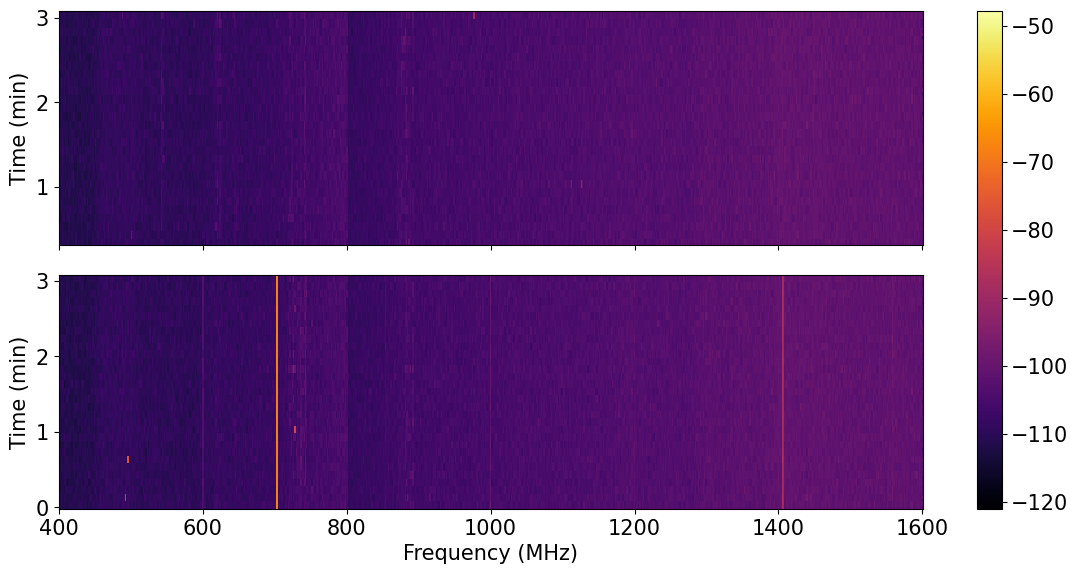

In [13]:
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
import glob
import pandas as pd
def read_directory(directory):
    file_list = sorted(glob.glob(directory))
    power_data = []  # List to store power matrices
    time_stamps = []  # Time steps (assume evenly spaced)

    for i, file in enumerate(file_list):
        freq, power = snapshot = np.loadtxt(file, delimiter=' ')  # Load power values
        power_data.append(power)
        time_stamps.append(i)  # Assume evenly spaced time steps
    
    # 🔹 Step 2: Convert list to 2D array
    power_data = np.array(power_data)  # Shape (time_steps, freq_bins)
    
    # 🔹 Step 3: Define frequency bins (assuming known range)
    freq_bins = np.linspace(400, 1600, power_data.shape[1])

    return power_data, freq_bins, time_stamps

data1, freq_bins1, time_stamps1  = read_directory("./march_20_spectrum/rfi_box_phone_1/*")

# calibration_run =  glob.glob("./march_25_spectrum/*rfexplorer")[0]
# freq_bins2, time_stamps2, data2 = read_spectrum_csv(calibration_run)

data2, freq_bins2, time_stamps2 = read_directory("./march_20_spectrum/rfi_box_cmb_1/*")

scale = data2.max()

gain_cal = pd.read_csv("gain_cal.csv")
gain_scale = np.interp(freq_bins1*1E6, gain_cal["Frequency"], gain_cal['dB'])
data1 = data1 - gain_scale

gain_cal = pd.read_csv("gain_cal.csv")
gain_scale = np.interp(freq_bins2*1E6, gain_cal["Frequency"], gain_cal['dB'])
data2 = data2 - gain_scale

vmin = data2.min() 
vmax = data2.max() 

dt = 2
time1 = np.array(time_stamps1)*dt/60
time2 = np.array(time_stamps2)*dt/60

mask1 = time1 < 3+0.1
mask2 = time2 < 3+0.1

data1 = max_pooling_2d(data1, 3)
data2 = max_pooling_2d(data2, 3)


# Create a common norm for both plots
norm = mcolors.Normalize(vmin=vmin, vmax=vmax+20)

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# First plot
im1 = ax1.pcolormesh(freq_bins1, time1[mask1][10:], data1[mask1][10:], norm=norm, shading='auto', cmap='inferno')
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))

ax1.set_ylabel("Time (min)")

# Second plot
im2 = ax2.pcolormesh(freq_bins2, time2[mask2], data2[mask2],norm=norm, shading='auto', cmap='inferno' )
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_xlabel("Frequency (MHz)")
ax2.set_ylabel("Time (min)")

# Add a common colorbar
plt.tight_layout()
fig.colorbar(im1, ax=[ax1, ax2], orientation="vertical")
print(np.max(data2))

plt.savefig("./Figs/no_signal+rfi_explorer.png", dpi=500, format="png", transparent=False)
plt.show()

Top ./march_26_spectrum/2025-03-24_18.34.29.2.phonecall_large
Bottom ./march_26_spectrum/2025-03-24_18.34.29.2.phonecall_large
(1219, 250)
(1219, 250)
-25.1875


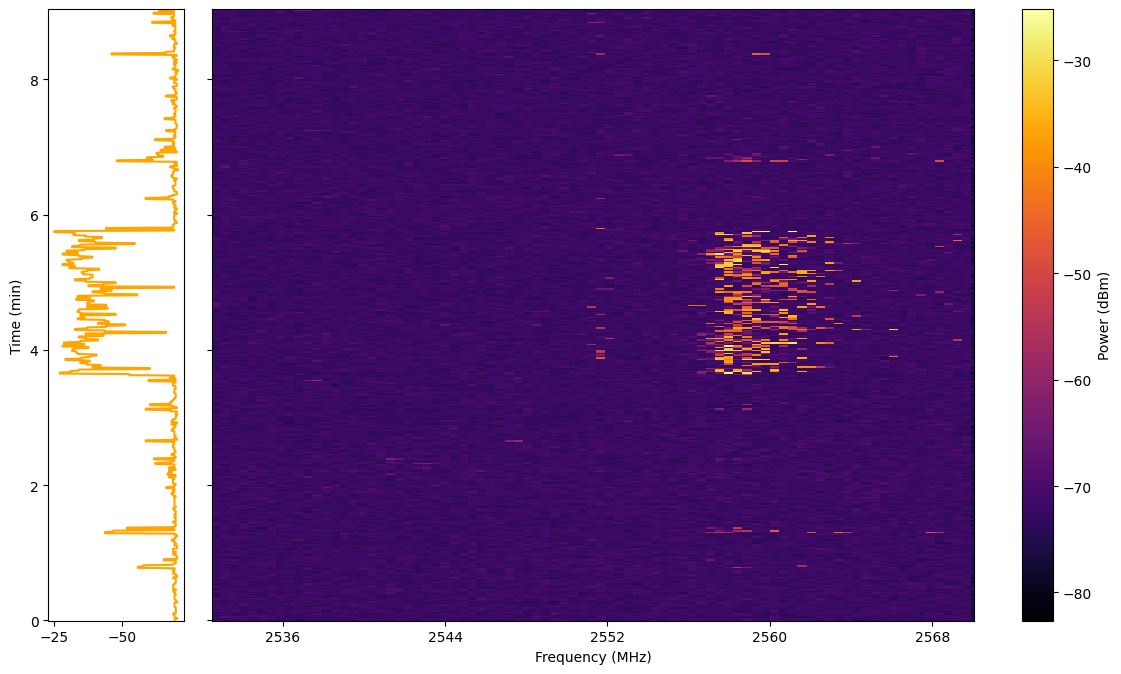

AttributeError: module 'matplotlib.pyplot' has no attribute 'grid_lines'

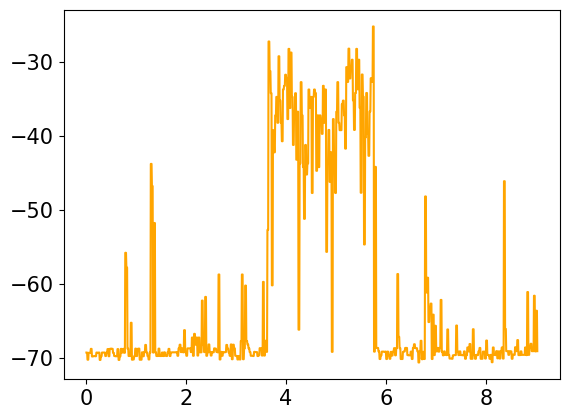

In [11]:
import csv
import numpy as np

# Define the CSV file to read
trial2 = glob.glob("./march_26_spectrum/*large")[0]
trial1  = glob.glob("./march_26_spectrum/*large")[0]

print("Top", trial2)
print("Bottom", trial1)
# Function to read the CSV file



dt = 0.445



def read_spectrum_csv(csv_file):
    with open(csv_file, "r") as f:
        reader = csv.reader(f)
        data = list(reader)  # Read entire file into a list

    # Extract frequency bins from the first row (excluding "Scan ID")
    frequencies = np.array(data[0][1:], dtype=float)

    # Extract power data (skipping the header row)
    scan_ids = []
    power_data = []
    
    for row in data[1:]:
        scan_ids.append(int(row[0]))  # First column is the scan ID
        power_data.append(np.array(row[1:], dtype=float))  # Convert power values to float

    power_data = np.array(power_data)  # Convert list to NumPy array for easy processing

    return frequencies, scan_ids, power_data

# Read the CSV file
frequencies, scan_ids, power_data = read_spectrum_csv(trial2)
# power_data1 = power_data - scale
power_data1 = power_data

########################
#crop
scan_ids = np.array(scan_ids[300:1800])-300
power_data1 = power_data[300:1900, 250:]

print(np.shape(power_data1))
frequencies = frequencies[250:]
########################
scan_ids = np.array(scan_ids)
time = scan_ids*dt/60
free_path_loss = -35.57

vmin = power_data1.min() 
vmax = power_data1.max()

# Create a common norm for both plots
# norm = mcolors.Normalize(vmin=vmin, vmax=vmax)


gain_cal = pd.read_csv("gain_cal.csv")
gain_scale = np.interp(frequencies, gain_cal["Frequency"], gain_cal['dB'])
# power_data1 = power_data1 - gain_scale

print(np.shape(power_data1))

print(np.max(power_data1))
# fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))

# im = ax1.pcolormesh(frequencies/1E6, time, power_data1, shading='auto', cmap='inferno')


# fig.colorbar(im, orientation="vertical", label='Power At Antenna [dBm]')
# ax1.set_xlabel(r"Frequency [MHz]")
# ax1.set_ylabel(r"Time [min]")

# #bbox_inches

# plt.savefig("./Figs/cellphone.tiff", dpi=300, format="tiff")
# plt.show()
def max_pooling_2d(data, pool_size):
    pooled_data = data.copy()
    for i in range(0, data.shape[0] - pool_size + 1, pool_size):
        for j in range(0, data.shape[1] - pool_size + 1, pool_size):
            pooled_data[i:i+pool_size, j:j+pool_size] = np.max(data[i:i+pool_size, j:j+pool_size])
    return pooled_data

power_data1 = max_pooling_2d(power_data1, 3)


max_power = np.max(power_data1, axis=1)

# Create the plot
fig, ax = plt.subplots(1, 2, figsize=(12, 7), gridspec_kw={'width_ratios': [1, 7]}, sharey=True)

# Maximum power plot
ax[0].plot(max_power, time, color='orange')
# ax[0].set_xlabel('Max Power (dB)'
ax[0].set_ylabel('Time (min)')
# # ax[0].set_title('Max Spectrum')
ax[0].invert_xaxis()  # Flip the axis for better alignment
# ax[0].tick_params(axis='x', bottom=False, labelbottom=False) 



# Waterfall plot
pcm = ax[1].pcolormesh(frequencies/1E6, time, power_data1, shading='auto', cmap='inferno')
# pcm.set_clim(vmin=np.min(power_data1), vmax=np.max(power_data1))
fig.colorbar(pcm, ax=ax[1], label='Power (dBm)')
ax[1].set_xlabel('Frequency (MHz)')

from matplotlib.ticker import MaxNLocator
ax[1].xaxis.set_major_locator(MaxNLocator(nbins=5))

# fig.axhspan(2, 4, edgecolor='red', facecolor='none', alpha=0.85)

plt.rcParams.update({'font.size': 15})

plt.tight_layout()
# plt.savefig("./Figs/cellphone.png", dpi=500, format="png", transparent=False)
plt.show()

plt.plot(time, max_power,  color='orange')
plt.grid_lines()


[[-70.0625  -66.5625  -71.0625  ... -91.5     -90.96875 -91.96875]
 [-73.59375 -74.5625  -74.5625  ... -91.      -87.      -89.     ]
 [-66.0625  -66.0625  -68.0625  ... -91.      -91.46875 -88.5    ]
 ...
 [-68.65625 -74.65625 -66.65625 ... -92.59375 -92.09375 -89.59375]
 [-71.15625 -68.65625 -73.15625 ... -89.59375 -88.5625  -88.5625 ]
 [-68.15625 -75.15625 -70.65625 ... -90.5625  -89.09375 -91.09375]]
[[-67.84375 -71.3125  -69.3125  ... -92.75    -91.71875 -86.75   ]
 [-66.3125  -71.8125  -72.8125  ... -91.21875 -90.21875 -87.21875]
 [-74.8125  -71.3125  -70.8125  ... -90.21875 -90.75    -90.25   ]
 ...
 [-68.65625 -74.65625 -66.65625 ... -92.59375 -92.09375 -89.59375]
 [-71.15625 -68.65625 -73.15625 ... -89.59375 -88.5625  -88.5625 ]
 [-68.15625 -75.15625 -70.65625 ... -90.5625  -89.09375 -91.09375]]
(158, 2000)
(158, 2000)
-31.871276889544774


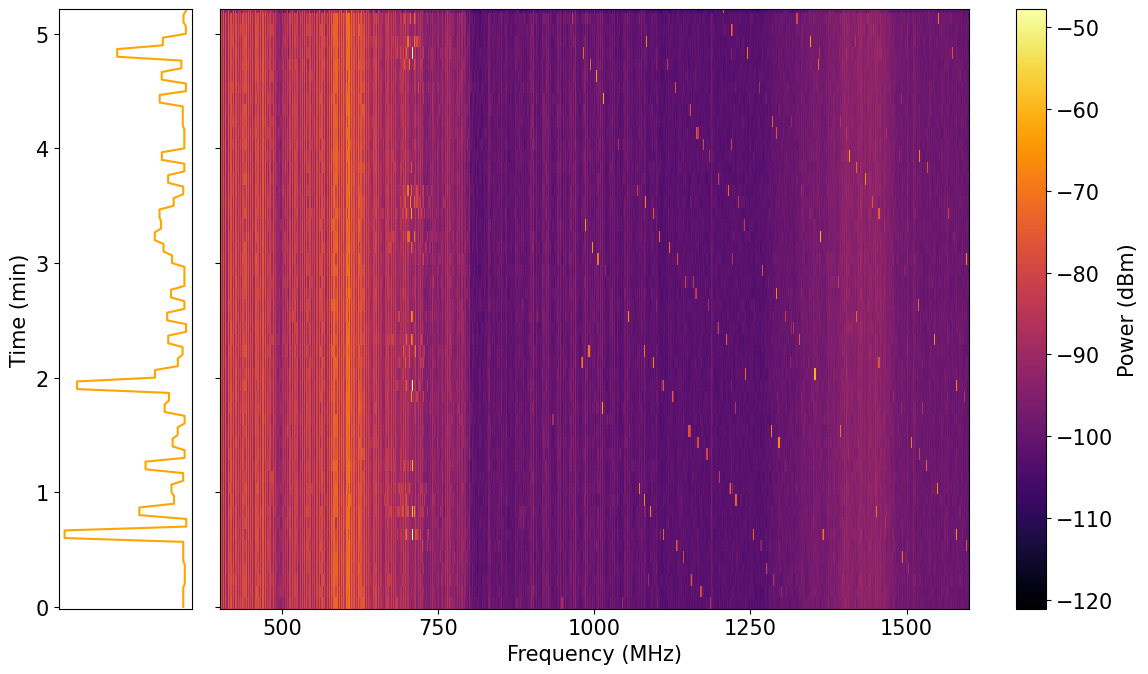

In [337]:
import csv
import numpy as np

# Define the CSV file to read
trial2 = glob.glob("./april_2_spectrum/*")[0]


# Function to read the CSV file



dt = 2




# Read the CSV file
frequencies, scan_ids, power_data = read_spectrum_csv(trial2)
power_data1 = power_data


########################
#crop
scan_ids = np.array(scan_ids[100:300])-100
print(power_data1)
power_data1 = power_data1[100:300]

print(power_data1)
print(np.shape(power_data1))
# frequencies = frequencies[300:]
########################
scan_ids = np.array(scan_ids)
time = scan_ids*dt/60
free_path_loss = -35.57



gain_cal = pd.read_csv("gain_cal.csv")
gain_scale = np.interp(frequencies, gain_cal["Frequency"], gain_cal['dB'])
power_data1 = power_data1 - gain_scale

print(np.shape(power_data1))

print(np.max(power_data1))
# fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))

# im = ax1.pcolormesh(frequencies/1E6, time, power_data1, shading='auto', cmap='inferno')


# fig.colorbar(im, orientation="vertical", label='Power At Antenna [dBm]')
# ax1.set_xlabel(r"Frequency [MHz]")
# ax1.set_ylabel(r"Time [min]")

# #bbox_inches

# plt.savefig("./Figs/cellphone.tiff", dpi=300, format="tiff")
# plt.show()

power_data1 = max_pooling_2d(power_data1, 3)


max_power = np.max(power_data1, axis=1)

# Create the plot
fig, ax = plt.subplots(1, 2, figsize=(12, 7), gridspec_kw={'width_ratios': [1, 7]}, sharey=True)

# Maximum power plot

ax[0].plot(max_power[:-1], time[:-1], color='orange')
# ax[0].set_xlabel('Max Power (dB)'
ax[0].set_ylabel('Time (min)')
# ax[0].set_title('Max Spectrum')
ax[0].invert_xaxis()  # Flip the axis for better alignment
ax[0].tick_params(axis='x', bottom=False, labelbottom=False) 



# Waterfall plot
pcm = ax[1].pcolormesh(frequencies/1E6, time[:-1], power_data1[:-1], norm= norm, shading='auto',cmap='inferno')
# pcm.set_clim(vmin=np.min(power_data1), vmax=np.max(power_data1))
fig.colorbar(pcm, ax=ax[1], label='Power (dBm)')
ax[1].set_xlabel('Frequency (MHz)')

from matplotlib.ticker import MaxNLocator
ax[1].xaxis.set_major_locator(MaxNLocator(nbins=5))

# fig.axhspan(2, 4, edgecolor='red', facecolor='none', alpha=0.85)

plt.rcParams.update({'font.size': 15})

plt.tight_layout()
plt.savefig("./Figs/sys_rfi.png", dpi=500, format="png", transparent=False)
plt.show()


**VIEW PORT**
=============

-91.52666829831138


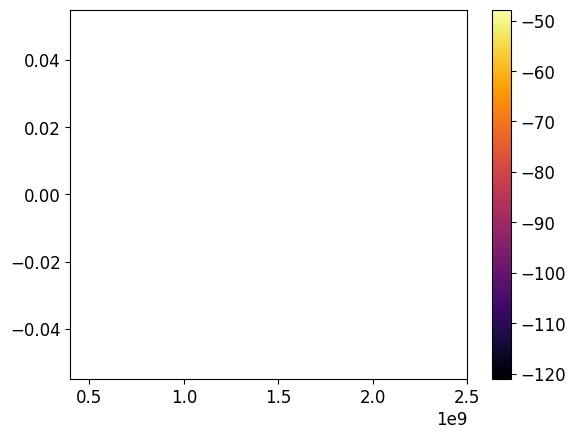

In [345]:
trial2 = glob.glob("./april_2_spectrum/*8.1")[0]
plt.rcParams.update({'font.size': 12})

frequencies, scan_ids, power_data = read_spectrum_csv(trial2)
# power_data1 = power_data - scale
power_data1 = power_data

gain_cal = pd.read_csv("gain_cal.csv")
gain_scale = np.interp(frequencies, gain_cal["Frequency"], gain_cal['dB'])
power_data1 = power_data1 - gain_scale

print(np.max(power_data1))

plt.pcolormesh(frequencies, scan_ids, power_data1,norm=norm, shading='auto', cmap='inferno')
plt.colorbar(orientation="vertical")
plt.show()

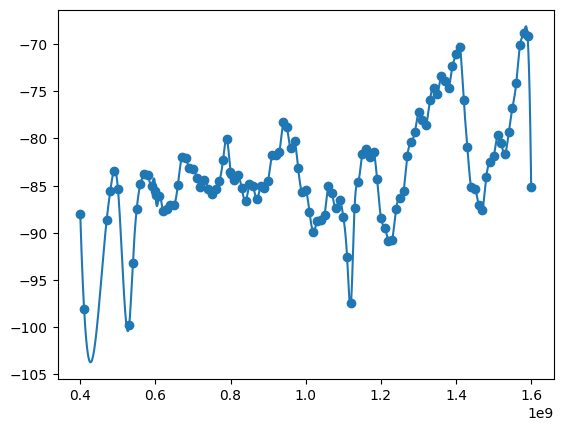

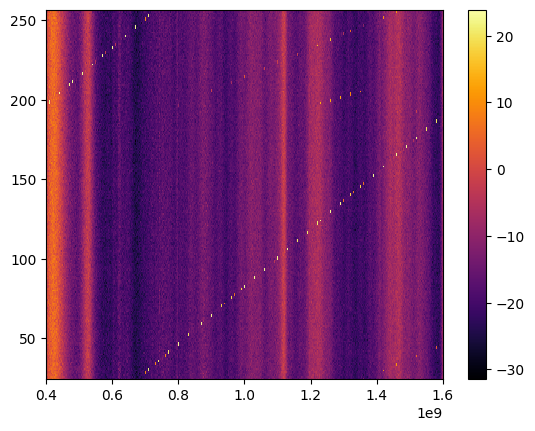

In [91]:
from scipy.signal import decimate
from scipy.interpolate import CubicSpline
import pandas as pd



calibration_run =  glob.glob("./march_25_spectrum/*rfexplorer")[0]

frequencies, scan_ids, power_data = read_spectrum_csv(calibration_run)

#grab the correct data
scan_ids = scan_ids[25:-50]
power_data = power_data[25:-50]

power_data = scale(power_data, frequencies)

#get the brightest element in column/row hopefully that is the rf explorer
max_col = np.max(power_data, axis=0, keepdims=True)
max_row = np.max(power_data, axis=1, keepdims=True)

mask = (power_data == max_row) & (power_data == max_col)
mask_freq = np.any(mask, axis=0) 

freq_trimmed = frequencies[mask_freq]
power_trimmed = power_data * mask
power_max= -1*np.max(np.abs(power_trimmed), axis=0)

# plt.plot(frequencies, power_max)

mask2 = power_max != 0
freq_trimmed = frequencies[mask2]
power_trimmed = power_max[mask2] - 22.6 #plus emittor power

plt.scatter(freq_trimmed, power_trimmed)


#interpolate in between the frequencies we have to the ones we don't
power_interp = np.interp(frequencies, freq_trimmed, power_trimmed)
cs = CubicSpline(freq_trimmed, power_trimmed)

plt.plot(frequencies, cs(frequencies))


power_interp = cs(frequencies) 

plt.show()
plt.pcolormesh(frequencies, scan_ids, power_data - power_interp, shading='auto', cmap='inferno')
plt.colorbar()

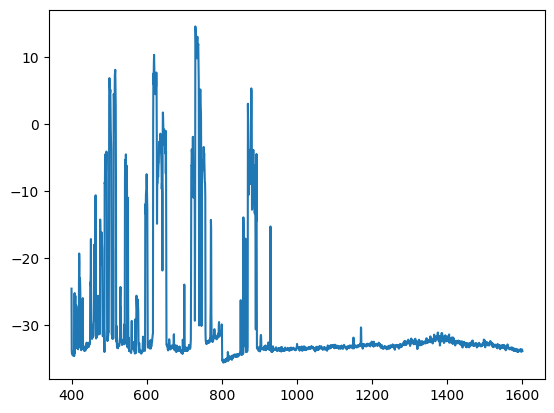

In [151]:
squashed2 = np.mean(power_data, axis=0)
squashed1 = np.mean(power_data1, axis=0)
# plt.plot(frequencies, squashed2)
plt.plot(frequencies, squashed1)

NameError: name 'read_run' is not defined

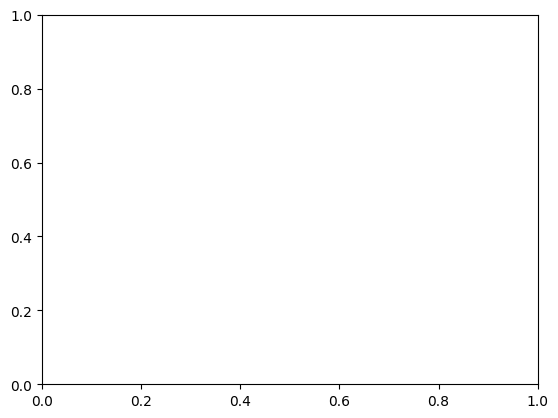

In [107]:
runs  = ['max_hold_cal', 'phone_5stack_max_hold_test_1', 'phone_5stack_maxhold_test_2', 'open_faraday_cage_test_3']
run_name = ["Empty Cage",  "Cellphone RFI 2", "Cellphone RFI 1", "Open Faraday cage "]

markers= ['o', 's', '^', 'o']
lines = ['-', '--','-.', '--']
colors = ['black', 'grey', 'black', 'grey',]
alpha = [1, 0.80, 0.60, 1]

delta = 0
split = 12

fig, ax = plt.subplots()

for run,name, marker, alp in zip(runs, run_name, markers, alpha):


        if '!' in run:
            continue
        
        frequency, power = read_run(run)

        if True:
            power = power + delta
            delta +=  split

        
        
        ax.set_ylim(-110, -0)
        ax.plot(frequency/1e6, power, label=name, markersize=3, alpha=alp)
        # ax.scatter(frequency[::10]/1e6, power[::10], marker=marker, s=20, alpha=0.75)
        ax.set_xlabel('Frequency [MHz]')
        ax.set_title("Faraday Cage Test of Cellphone RFI")

        ax.set_yticks([])  # Remove ticks
        ax.set_yticklabels([])  # Remove tick labels
        ax.set_ylabel('Power [dBm]')
        
        
        # plt.vlines(876, -110,0, color='k', linestyle='--', linewidth=0.75)
    
        # plt.xlim(400, 1600)
        ax.grid(True, linestyle=':', linewidth=0.5)
        
    


handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))

plt.savefig("Figs/faraday_cage_test.svg")

plt.show()
f, p = read_run("max_hold_cal")


np.mean(p)


f,p = read_run("phone_5stack_max_hold_test_1")

np.max(p)

peak_idx = [ 28  50  93 156 195 232 283 319 376 439 474]


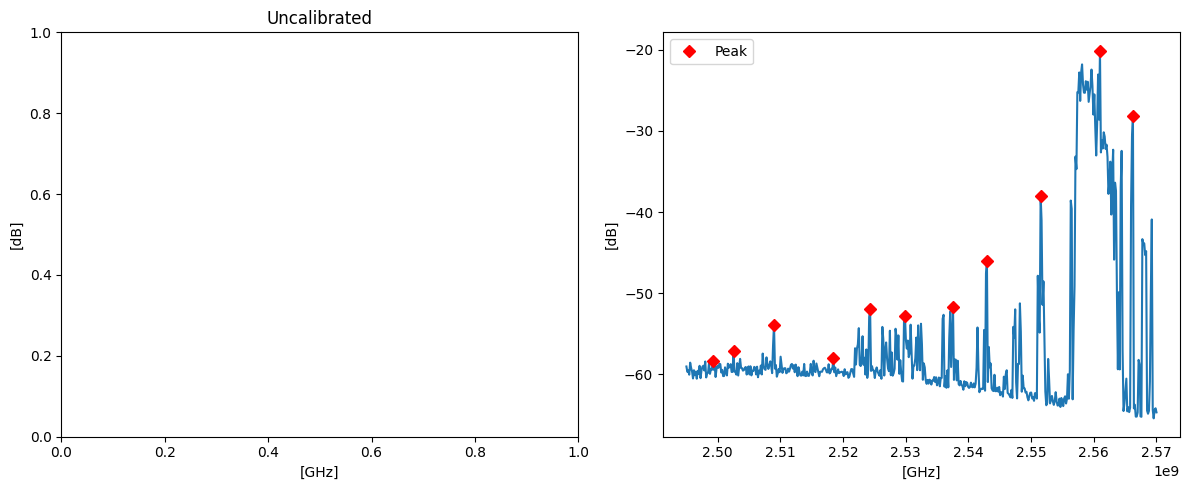

In [117]:
# rf_on = read_run('phone_5stack_max_hold_test_1')
# closed_faraday = read_run('max_hold_cal')

# calibrated = rf_on[1] - closed_faraday[1]

# frequency = rf_on[0]
# power = calibrated

power = np.max(power_data1, axis=0)
frequency = frequencies

# plt.ylim(-110, -40)
peak_idx = detect_peaks(power, num_train=40, num_guard=2, rate_fa=1e-5)
           
print("peak_idx =", peak_idx)

fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Step 5: Plot data on each subplot
# Plot on the first subplot
ax1.plot(frequency, power)
ax1.plot(frequency[peak_idx], power[peak_idx], 'rD', label='Peak')

ax1.set_xlabel('[GHz]')
ax1.set_ylabel('[dB]')
ax1.legend()

# Plot on the second subplot
# ax2.plot(rf_on[0], rf_on[1], label='power')
# ax2.plot(rf_on[0][peak_idx], rf_on[1][peak_idx], 'rD', label='Peak')
# ax2.set_ylim(-110, -0)

ax2.set_title('Uncalibrated')
ax2.set_xlabel('[GHz]')
ax2.set_ylabel('[dB]')
# ax2.legend()

# Step 6: Display the plots
plt.tight_layout()
plt.show()

In [108]:
#from https://tsaith.github.io/detect-peaks-with-cfar-algorithm.html
def detect_peaks(x, num_train, num_guard, rate_fa):
    """
    Detect peaks with CFAR algorithm.
    
    num_train: Number of training cells.
    num_guard: Number of guard cells.
    rate_fa: False alarm rate. 
    """
    num_cells = x.size
    num_train_half = round(num_train / 2)
    num_guard_half = round(num_guard / 2)
    num_side = num_train_half + num_guard_half
 
    alpha = num_train*(rate_fa**(-1/num_train) - 1) # threshold factor
    
    peak_idx = []
    for i in range(num_side, num_cells - num_side):
        
        if i != i-num_side+np.argmax(x[i-num_side:i+num_side+1]): 
            continue
        
        sum1 = np.sum(x[i-num_side:i+num_side+1])
        sum2 = np.sum(x[i-num_guard_half:i+num_guard_half+1]) 
        p_noise = (sum1 - sum2) / num_train 
        threshold = alpha * p_noise
        
        if x[i] > threshold: 
            peak_idx.append(i)
    
    peak_idx = np.array(peak_idx, dtype=int)
    
    return peak_idx